In [2]:
import pandas as pd
import numpy as np
import os
import socket
from tqdm import tqdm

# libraries to parallelize code
import multiprocessing as mp
from joblib import Parallel, delayed
import matplotlib.pyplot as plt


In [4]:
path_training= "./data/training_data.csv"

df = pd.read_csv(path_training, error_bad_lines=False,encoding='utf-8',sep="\t")
df

,eval,set_ratio,sort_ratio,ratio,overlap,soundex,score,max,reverse,x_name,y_name,x_id,y_id
0,1,93,93,93,1.0,1,281.0,281.0,0,various artists,various aritsts,1,4883
1,1,100,100,100,1.0,1,302.0,302.0,0,various artists,various artists,1,4884
2,1,100,100,100,1.0,1,302.0,302.0,0,massive attack,massive attack,4,2982
3,1,100,100,100,1.0,1,302.0,302.0,0,robert miles,robert miles,9,3922
4,1,100,100,100,1.0,1,302.0,302.0,0,bob dylan,bob dylan,17,528
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7649,1,100,100,100,1.0,1,302.0,302.0,0,joe cocker & jennifer warnes,joe cocker & jennifer warnes,1388122,2294
7650,1,100,100,100,1.0,1,302.0,302.0,0,nirvana,nirvana,1388316,3360
7651,1,100,100,100,1.0,1,302.0,302.0,0,vip,vip,1388405,4855
7652,1,100,100,47,1.0,0,248.0,248.0,1,suzanne collins,collins suzanne,1388451,875


In [139]:
x = df[["x_id","x_name"]]
y = df[['y_id','y_name',"eval"]]
del df['eval']

In [140]:
x_final = x.drop_duplicates()
y_final = y.drop_duplicates()

In [141]:
from sklearn.feature_extraction.text import TfidfVectorizer
#ngram best result

import re
import time
from ftfy import fix_text #  text c<leaning for decode issues..
from scipy.sparse import csr_matrix # may not be required 
from scipy.sparse import rand # may not be required
import nmslib

In [142]:
def ngrams(string, n=2):
    """Takes an input string, cleans it and converts to ngrams. 
    This script is focussed on cleaning UK company names but can be made generic by removing lines below"""
    string = str(string)
    string = string.lower() # lower case
    string = fix_text(string) # fix text
    string = string.split('t/a')[0] # split on 'trading as' and return first name only
    #string = string.split('trading as')[0] # split on 'trading as' and return first name only
    string = string.encode("ascii", errors="ignore").decode() #remove non ascii chars
    chars_to_remove = [")","(",".","|","[","]","{","}","'","-"]
    rx = '[' + re.escape(''.join(chars_to_remove)) + ']' #remove punc, brackets etc...
    string = re.sub(rx, '', string)
    string = string.replace('&', 'and')
    #string = string.replace('limited', 'ltd')
    #string = string.replace('public limited company', 'plc')
    #string = string.replace('united kingdom', 'uk')
    #string = string.replace('community interest company', 'cic')
    string = string.title() # normalise case - capital at start of each word
    string = re.sub(' +',' ',string).strip() # get rid of multiple spaces and replace with a single
    string = ' '+ string +' ' # pad names for ngrams...
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

In [143]:
article_name = list(y_final['y_name'][:].unique())
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(article_name)

# messy data => EX: popsike data
messy_tracks = list(x_final['x_name'][:].dropna().unique())
messy_tf_idf_matrix = vectorizer.transform(messy_tracks)

In [144]:
# create a random matrix to index
data_matrix = tf_idf_matrix#[0:1000000]

# Set index parameters
# These are the most important ones
M = 80
efC = 1000

num_threads = 4 # adjust for the number of threads
# Intitialize the library, specify the space, the type of the vector and add data points 
index = nmslib.init(method='simple_invindx', space='negdotprod_sparse_fast', data_type=nmslib.DataType.SPARSE_VECTOR) 

index.addDataPointBatch(data_matrix)
# Create an index
start = time.time()
index.createIndex() 
end = time.time() 
print('Indexing time = %f' % (end-start))

# c'est là que ça prend le plus de temps
# Number of neighbors => use Knn
num_threads = 4
K=1
query_matrix = messy_tf_idf_matrix
start = time.time() 
query_qty = query_matrix.shape[0]
nbrs = index.knnQueryBatch(query_matrix, k = K, num_threads = num_threads)
end = time.time() 
print('kNN time total=%f (sec), per query=%f (sec), per query adjusted for thread number=%f (sec)' % 
      (end-start, float(end-start)/query_qty, num_threads*float(end-start)/query_qty))

mts =[]
for i in range(len(nbrs)):
  origional_nm = messy_tracks[i] #changer les noms mais du coup le original c'est bien musicbrainz qui est le original et popsike le atched name
  try:
    matched_nm   = article_name[nbrs[i][0][0]]
    conf         = nbrs[i][1][0]
  except:
    matched_nm   = "no match found"
    conf         = None
  mts.append([origional_nm,matched_nm,conf])

mts = pd.DataFrame(mts,columns=['origional_name','matched_name','conf'])
mts['conf'] = -mts['conf'] #otherwise -1 represent confidence = 100%
#results = df_CF.merge(mts,left_on='buyer',right_on='origional_name')
print(mts)
mts = mts.sort_values(["conf"], ascending=False)

Indexing time = 0.007575
kNN time total=0.331187 (sec), per query=0.000080 (sec), per query adjusted for thread number=0.000321 (sec)
                    origional_name                  matched_name      conf
0                  various artists               various artists  1.000000
1                   massive attack                massive attack  1.000000
2                     robert miles                  robert miles  1.000000
3                        bob dylan                     bob dylan  1.000000
4                        tom waits                     waits tom  1.000000
...                            ...                           ...       ...
4116                  bradley hale               bradley charles  0.716195
4117                     t pinnock                  pinnock & ec  0.622408
4118                   dan padilla                  juan padilla  0.729556
4119                   rino christ                      christer  0.620590
4120  joe cocker & jennifer warnes  joe c

In [145]:
df_test = mts.merge(x_final, how="left",left_on="origional_name", right_on="x_name")
df_test = df_test.merge(y_final, how="left",left_on="matched_name", right_on="y_name")
del df_test['x_name']
del df_test['y_name']
df_test

,origional_name,matched_name,conf,x_id,y_id,eval
0,gavin degraw,degraw gavin,1.000000,106120,1077,1
1,wilkinson,wilkinson,1.000000,722265,5040,1
2,chris avedon & coon,chris avedon & coon,1.000000,827178,789,1
3,captain hollywood project,captain hollywood project,1.000000,1879,711,1
4,ariana grande,grande ariana,1.000000,823336,1845,1
...,...,...,...,...,...,...
6306,rka markov,parov stelar,0.412739,1068440,3553,1
6307,mel larned,bill medley & jennifer warnes,0.409694,716277,453,1
6308,tj upshaw,tjr,0.357160,1233772,4725,1
6309,tnu kaljuste,estonian pcc & estonian national so & kaljuste,0.353035,242257,1476,0


In [151]:
df_final = df_test.merge(df, how="left",left_on="x_id", right_on="x_id")
df_final = df_final.drop(columns=['set_ratio','sort_ratio','ratio','overlap','soundex','score','max','reverse'])
df_final['eval_fuzz'] = [1 if s >=0.5 else 0 for s in df_final['conf']]
df_final
#eval column

,origional_name,matched_name,conf,x_id,y_id_x,eval,x_name,y_name,y_id_y,eval_fuzz
0,gavin degraw,degraw gavin,1.000000,106120,1077,1,gavin degraw,degraw gavin,1077,1
1,wilkinson,wilkinson,1.000000,722265,5040,1,wilkinson,wilkinson,5040,1
2,chris avedon & coon,chris avedon & coon,1.000000,827178,789,1,chris avedon & coon,chris avedon & coon,789,1
3,captain hollywood project,captain hollywood project,1.000000,1879,711,1,captain hollywood project,captain hollywood project,711,1
4,ariana grande,grande ariana,1.000000,823336,1845,1,ariana grande,ariana grande,225,1
...,...,...,...,...,...,...,...,...,...,...
8038,rka markov,parov stelar,0.412739,1068440,3553,1,rka markov,gergiev & pape & markov & semishkur &,1772,0
8039,mel larned,bill medley & jennifer warnes,0.409694,716277,453,1,mel larned,mdel bjarne,3243,0
8040,tj upshaw,tjr,0.357160,1233772,4725,1,tj upshaw,latry & upshaw & muraro & boulez & nagano & &,2678,0
8041,tnu kaljuste,estonian pcc & estonian national so & kaljuste,0.353035,242257,1476,0,tnu kaljuste,prt & estonian pcc & estonian nsc & kaljuste,3773,0


In [148]:
TP = 0
TN = 0
FP = 0
FN = 0

for i in range(len(df_final[:])):
    if df_final['eval_fuzz'].loc[i] == 1 and df_final['eval'].loc[i] == 1:
        TP += 1
    elif df_final['eval_fuzz'].loc[i] == 0 and df_final['eval'].loc[i] == 0:
        TN += 1
    elif df_final['eval_fuzz'].loc[i] == 0 and df_final['eval'].loc[i] == 1:
        FN += 1
    else:
        FP += 1

TPR = TP / (TP+FN)
FPR = FP / (TN+FP)
list_tpr.append(TPR)
list_fpr.append(FPR)
accuracy_score = round(TP/len(df_final[:]),4)
print(f'Accuracy score: {accuracy_score*100}%') #accuracy score: 77%
print(f'TPR: {TPR}')
print(f'FPR: {FPR}')

Accuracy score: 90.60000000000001%
TPR: 0.9935914916825743
FPR: 0.9590973201692524


cuteoff: 0.0
Accuracy score: 91.18%
cuteoff: 0.05
Accuracy score: 91.18%
cuteoff: 0.1
Accuracy score: 91.18%
cuteoff: 0.15000000000000002
Accuracy score: 91.18%
cuteoff: 0.2
Accuracy score: 91.18%
cuteoff: 0.25
Accuracy score: 91.18%
cuteoff: 0.30000000000000004
Accuracy score: 91.18%
cuteoff: 0.35000000000000003
Accuracy score: 91.17%
cuteoff: 0.4
Accuracy score: 91.16%
cuteoff: 0.45
Accuracy score: 91.02%
cuteoff: 0.5
Accuracy score: 90.60000000000001%
cuteoff: 0.55
Accuracy score: 89.88000000000001%
cuteoff: 0.6000000000000001
Accuracy score: 88.7%
cuteoff: 0.65
Accuracy score: 87.19%
cuteoff: 0.7000000000000001
Accuracy score: 84.74000000000001%
cuteoff: 0.75
Accuracy score: 81.6%
cuteoff: 0.8
Accuracy score: 79.14999999999999%
cuteoff: 0.8500000000000001
Accuracy score: 77.41%
cuteoff: 0.9
Accuracy score: 76.41%
cuteoff: 0.9500000000000001
Accuracy score: 76.03999999999999%
cuteoff: 1.0
Accuracy score: 63.24999999999999%
cuteoff: 1.05
Accuracy score: 0.0%


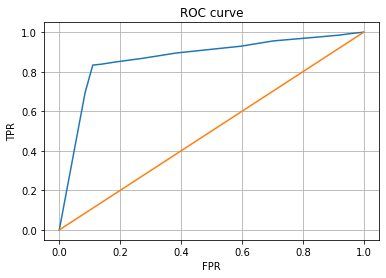

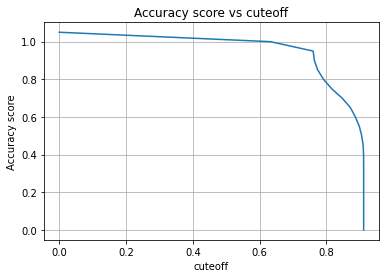

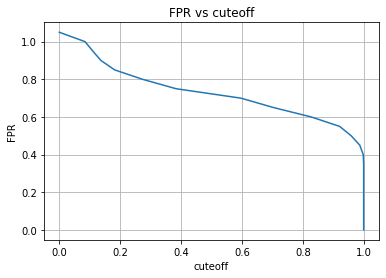

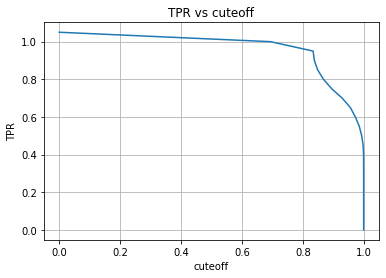

In [160]:
# problem with this algos
cuteoff = np.arange(0,1.1,0.05)
#cuteoff = [0.4,0.5,0.6,0.7,0.8]
list_tpr = []
list_fpr = []
list_accuracy = []
for j in cuteoff:
    print(f'cuteoff: {j}')
    df_final = df_test.merge(df, how="left",left_on="x_id", right_on="x_id")
    df_final = df_final.drop(columns=['set_ratio','sort_ratio','ratio','overlap','soundex','score','max','reverse'])
    df_final['eval_fuzz'] = [1 if s >=j else 0 for s in df_final['conf']]
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for i in range(len(df_final[:])):
        if df_final['eval_fuzz'].loc[i] == 1 and df_final['eval'].loc[i] == 1:
            TP += 1
        elif df_final['eval_fuzz'].loc[i] == 0 and df_final['eval'].loc[i] == 0:
            TN += 1
        elif df_final['eval_fuzz'].loc[i] == 0 and df_final['eval'].loc[i] == 1:
            FN += 1
        else:
            FP += 1

    TPR = TP / (TP+FN)
    FPR = FP / (TN+FP)
    list_tpr.append(TPR)
    list_fpr.append(FPR)
    accuracy_score = round(TP/len(df_final[:]),4)
    list_accuracy.append(accuracy_score)
    print(f'Accuracy score: {accuracy_score*100}%') #accuracy score: 77%
    #print(f'TPR: {TPR}')
    #print(f'FPR: {FPR}')

    #print(f'TP score: {TP}')
    #print(f'FP score: {FP}')
    #print(f'TN score: {TN}')
    #print(f'FN score: {FN}')

#ROC curve
line = np.arange(0,1.1,0.1)
fig = plt.figure()
plt.plot(list_fpr,list_tpr)
plt.plot(line,line)
plt.grid(True)
plt.title('ROC curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
fig.savefig('plots/fuzzymatching_roccurve.png')

# accuracy score vs cuteoff
fig = plt.figure()
plt.plot(list_accuracy,cuteoff)
plt.grid(True)
plt.title('Accuracy score vs cuteoff')
plt.xlabel('cuteoff')
plt.ylabel('Accuracy score')
plt.show()
fig.savefig('plots/accuracy_vs_cuteoff.png')
fig = plt.figure()

#FPR vs cuteoff
plt.plot(list_fpr,cuteoff)
plt.grid(True)
plt.title('FPR vs cuteoff')
plt.xlabel('cuteoff')
plt.ylabel('FPR')
plt.show()
fig.savefig('plots/FPR_vs_cuteoff.png')

# TPR vs cuteoffs
fig = plt.figure()
plt.plot(list_tpr,cuteoff)
plt.grid(True)
plt.title('TPR vs cuteoff')
plt.xlabel('cuteoff')
plt.ylabel('TPR')
plt.show()
fig.savefig('plots/TPR_vs_cuteoff.png')
